In [281]:
import pandas as pd
import numpy as np
import math
import sys
import os
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
pre_path = "./data/"

# Load data 


In [3]:
pre_file_list = os.listdir(pre_path)
data_df = pd.DataFrame()
col_list = []
for file in pre_file_list:
    #print(file)
    tmp_path = pre_path + file
    coin_type = file.split("USDT")[0]
    tmp_df = pd.read_csv(tmp_path)
    if len(col_list) == 0 and "close" in tmp_df.columns:
        col_list = tmp_df.columns
    out = [i for i, j in zip(col_list, tmp_df.columns) if i != j]
    if len(out) != 0:
        tmp_df = pd.read_csv(tmp_path,header = None)
        tmp_df.columns = col_list
    tmp_df["coin_type"] = coin_type
    tmp_df['open_time'] = tmp_df['open_time'].apply(lambda x: x//1000)
    tmp_df['open_time'] = pd.to_datetime(tmp_df['open_time'],unit='s')
    tmp_df['close_time'] = tmp_df['close_time'].apply(lambda x: x//1000)
    tmp_df['close_time'] = pd.to_datetime(tmp_df['close_time'],unit='s')
    data_df = pd.concat([data_df,tmp_df],axis = 0, ignore_index=True)

data_df = data_df.sort_values(by=['open_time',"coin_type"], ascending=True)
data_df = data_df.reset_index(drop = True)
display(data_df)

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,coin_type
0,2022-01-01 00:00:00,1.30770,1.33280,1.30760,1.32910,1.461367e+07,2022-01-01 00:59:59,1.930024e+07,29050,7.568545e+06,9.993614e+06,0,ADA
1,2022-01-01 00:00:00,511.55000,517.85000,511.43000,517.42000,2.932202e+04,2022-01-01 00:59:59,1.509610e+07,22736,1.591227e+04,8.192958e+06,0,BNB
2,2022-01-01 00:00:00,46210.57000,46729.73000,46210.55000,46650.01000,8.957465e+03,2022-01-01 00:59:59,4.164448e+08,91267,4.777701e+03,2.221296e+08,0,BTC
3,2022-01-01 00:00:00,3676.01000,3730.00000,3676.01000,3721.67000,4.583592e+04,2022-01-01 00:59:59,1.698204e+08,67207,2.553325e+04,9.462762e+07,0,ETH
4,2022-01-01 00:00:00,0.45057,0.45797,0.45002,0.45756,3.289705e+07,2022-01-01 00:59:59,1.494042e+07,30227,1.714832e+07,7.788349e+06,0,GALA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
165471,2023-11-30 23:00:00,0.26040,0.26210,0.25980,0.26190,1.004176e+07,2023-11-30 23:59:59,2.621476e+06,7398,5.443095e+06,1.421194e+06,0,GMT
165472,2023-11-30 23:00:00,14.31900,14.41000,14.28700,14.40700,4.770194e+05,2023-11-30 23:59:59,6.848692e+06,16444,2.734755e+05,3.927484e+06,0,LINK
165473,2023-11-30 23:00:00,0.76070,0.76330,0.75760,0.76260,1.260543e+07,2023-11-30 23:59:59,9.591372e+06,18852,6.195142e+06,4.714729e+06,0,MATIC
165474,2023-11-30 23:00:00,59.28400,59.30900,58.95300,59.30900,8.111330e+05,2023-11-30 23:59:59,4.799254e+07,54419,4.226510e+05,2.501009e+07,0,SOL


In [4]:
data_df = data_df.sort_values(['coin_type','open_time']).reset_index(drop=True)

# 1) Compute simple hourly return per coin:
#    r_{t} = (close_{t} / close_{t−1}) − 1
data_df['return'] = (
    data_df
    .groupby('coin_type')['close']
    .pct_change()           # percent change from previous timestamp (same coin)
)

# 2) (Optional) Drop the very first row per coin where return is NaN:
data_df = data_df.dropna(subset=['return']).reset_index(drop=True)

# Prepare data (Just using BTC)

In [5]:
# For illustration, let’s pick one coin: “BTCUSDT”
COIN = "BTC"

# 1) Filter for that coin and sort
df = data_df[data_df['coin_type'] == COIN].sort_values('open_time').reset_index(drop=True)

# 2) Compute the basic “label”: direction of next‐hour return
#    Label_t = 1 if return_{t+1} > 0, else 0.  We'll need to shift.
df['return'] = df['return']  # already exists
df['label_up'] = (df['return'].shift(-1) > 0).astype(int)

In [6]:
MAX_LAG = 6
L_MOM = 24
L_VOL = 24

for lag in range(1, MAX_LAG + 1):
    df[f'lag_ret_{lag}'] = df['return'].shift(lag)

df['mom_24h'] = df['close'].pct_change(periods=L_MOM)
df['vol_24h'] = df['return'].rolling(window=L_VOL, min_periods=L_VOL).std()

# 4) Drop NaNs in features/label
feature_cols = [f'lag_ret_{lag}' for lag in range(1, MAX_LAG + 1)] + ['mom_24h', 'vol_24h']
df_model = df.dropna(subset=feature_cols + ['label_up']).reset_index(drop=True)

# 5) Chronological split: Train/Val/Test
train_end = pd.to_datetime("2023-03-31 23:00:00")
val_end   = pd.to_datetime("2023-07-31 23:00:00")

train_mask = df_model['open_time'] <= train_end
val_mask   = (df_model['open_time'] > train_end) & (df_model['open_time'] <= val_end)
test_mask  = df_model['open_time'] > val_end

X_all = df_model[feature_cols].values
y_all = df_model['label_up'].values
times = df_model['open_time']
returns_series = df_model['return']

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# Standardize features for models that require scaling (Lasso, LSTM)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std   = scaler.transform(X_val)
X_test_std  = scaler.transform(X_test)

In [7]:
def compute_sharpe_from_signal(signal_series, returns_series):
    pnl = signal_series.shift(1).fillna(0) * returns_series
    avg_ret = pnl.mean()
    std_ret = pnl.std(ddof=0)
    return (avg_ret / std_ret) * np.sqrt(8760) if std_ret != 0 else np.nan, pnl, (1 + pnl.fillna(0)).cumprod()


# Training 

In [8]:
val_indices = df_model.index[val_mask]
test_indices = df_model.index[test_mask]

# Container for best models and their results
best_models = {}
model_results = {}

In [9]:

lasso_params = {'C': [0.01, 0.1, 1, 10, 100]}
best_sharpe = -np.inf
for C in lasso_params['C']:
    model = LogisticRegression(penalty='l1', solver='saga', C=C, max_iter=10000)
    model.fit(X_train_std, y_train)
    val_prob = model.predict_proba(X_val_std)[:,1]
    thr = 0.5
    sig = pd.Series(index=val_indices, data=0)
    sig[val_prob > thr] = 1
    sig[val_prob < (1 - thr)] = -1
    sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
    if sharpe_val > best_sharpe:
        best_sharpe = sharpe_val
        best_models['Lasso'] = {'model': model, 'C': C, 'threshold': thr, 'sharpe_val': sharpe_val}


In [10]:
xgb_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
best_sharpe = -np.inf
for n_est in xgb_grid['n_estimators']:
    for md in xgb_grid['max_depth']:
        for lr in xgb_grid['learning_rate']:
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                                  n_estimators=n_est, max_depth=md,
                                  learning_rate=lr, random_state=42, verbosity=0)
            model.fit(X_train, y_train)
            val_prob = model.predict_proba(X_val)[:,1]
            thr = 0.5
            sig = pd.Series(index=val_indices, data=0)
            sig[val_prob > thr] = 1
            sig[val_prob < (1 - thr)] = -1
            sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['XGBoost'] = {'model': model, 'n_estimators': n_est,
                                          'max_depth': md, 'learning_rate': lr,
                                          'threshold': thr, 'sharpe_val': sharpe_val}


In [11]:
cat_grid = {
    'iterations': [100, 200],
    'depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
best_sharpe = -np.inf
for it in cat_grid['iterations']:
    for d in cat_grid['depth']:
        for lr in cat_grid['learning_rate']:
            model = CatBoostClassifier(iterations=it, depth=d, learning_rate=lr,
                                       verbose=False, random_state=42)
            model.fit(X_train, y_train)
            val_prob = model.predict_proba(X_val)[:,1]
            thr = 0.5
            sig = pd.Series(index=val_indices, data=0)
            sig[val_prob > thr] = 1
            sig[val_prob < (1 - thr)] = -1
            sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['CatBoost'] = {'model': model, 'iterations': it,
                                          'depth': d, 'learning_rate': lr,
                                          'threshold': thr, 'sharpe_val': sharpe_val}


In [12]:
seq_features = [f'lag_ret_{lag}' for lag in range(1, MAX_LAG + 1)]

class LagDataset(Dataset):
    def __init__(self, df_model, mask, seq_features, label_col='label_up'):
        self.indices = df_model.index[mask]
        self.X = df_model.loc[mask, seq_features].values.astype('float32')
        self.y = df_model.loc[mask, label_col].values.astype('float32')
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        seq = self.X[idx].reshape(-1, 1)  # (seq_len, 1)
        return seq, self.y[idx]

def train_lstm_model(hidden_size, lr, epochs):
    # Prepare DataLoaders
    train_ds = LagDataset(df_model, train_mask, seq_features)
    val_ds   = LagDataset(df_model, val_mask, seq_features)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=False)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
    
    # Define model
    class LSTMModel(nn.Module):
        def __init__(self, input_size=1, hidden_size=16, num_layers=1):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc   = nn.Linear(hidden_size, 1)
        def forward(self, x):
            out, _ = self.lstm(x)
            h_last = out[:, -1, :]
            return torch.sigmoid(self.fc(h_last)).squeeze()
    
    model = LSTMModel(input_size=1, hidden_size=hidden_size, num_layers=1)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        for seq_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(seq_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
    
    # Validation inference
    model.eval()
    val_probs = []
    with torch.no_grad():
        for seq_batch, _ in val_loader:
            val_probs.append(model(seq_batch).numpy())
    val_probs = np.concatenate(val_probs, axis=0)
    
    thr = 0.5
    sig = pd.Series(index=val_indices, data=0)
    sig[val_probs > thr] = 1
    sig[val_probs < (1 - thr)] = -1
    sharpe_val, _, _ = compute_sharpe_from_signal(sig, returns_series[val_mask])
    return model, sharpe_val

# Hyperparameter grids for LSTM
hidden_sizes = [8, 16]
lrs = [1e-3, 1e-2]
epochs_list = [5, 10]

best_sharpe = -np.inf
for hs in hidden_sizes:
    for lr in lrs:
        for ep in epochs_list:
            model, sharpe_val = train_lstm_model(hs, lr, ep)
            if sharpe_val > best_sharpe:
                best_sharpe = sharpe_val
                best_models['LSTM'] = {'model': model, 'hidden_size': hs,
                                       'learning_rate': lr, 'epochs': ep,
                                       'threshold': 0.5, 'sharpe_val': sharpe_val}


Test Sharpe Ratios:
Lasso: Sharpe=-0.75
XGBoost: Sharpe=-1.74
CatBoost: Sharpe=0.91
LSTM: Sharpe=2.20


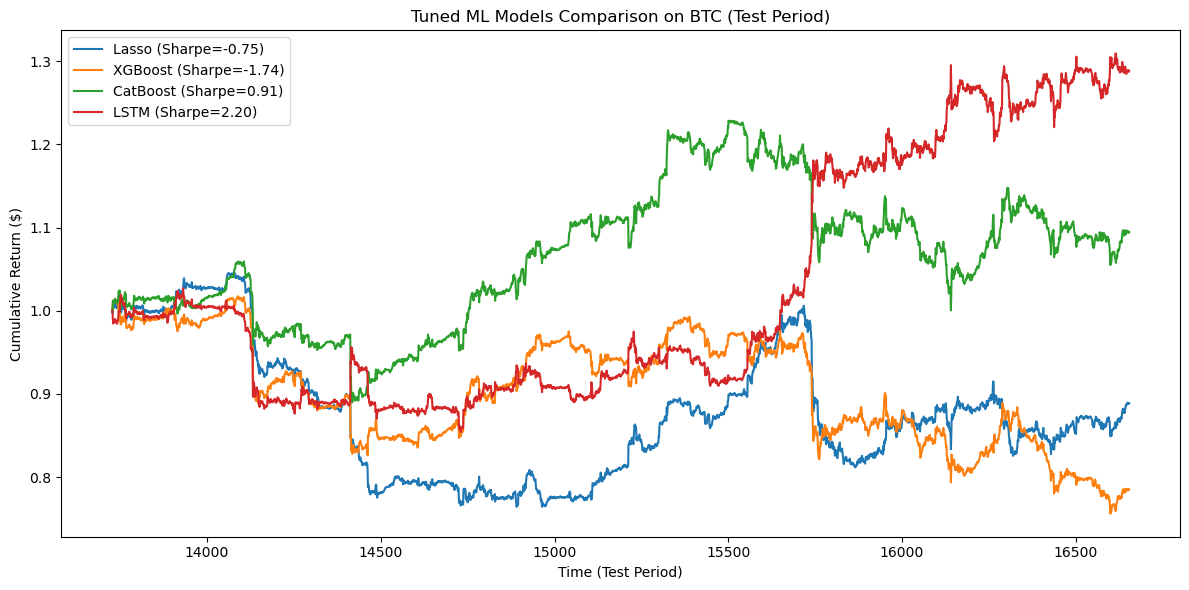


Best Hyperparameters:
Lasso: {'C': 1, 'threshold': 0.5, 'sharpe_val': 0.3612356994180074}
XGBoost: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01, 'threshold': 0.5, 'sharpe_val': 0.4049361088021661}
CatBoost: {'iterations': 200, 'depth': 3, 'learning_rate': 0.01, 'threshold': 0.5, 'sharpe_val': 0.2006895358771506}
LSTM: {'hidden_size': 8, 'learning_rate': 0.001, 'epochs': 5, 'threshold': 0.5, 'sharpe_val': 0.4064472994346425}


In [13]:
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(12, 6))
print("Test Sharpe Ratios:")
for name, info in best_models.items():
    if name in ['Lasso', 'XGBoost', 'CatBoost']:
        model = info['model']
        thr = info['threshold']
        # Choose correct features & scaling
        if name == 'Lasso':
            probs = model.predict_proba(X_test_std)[:, 1]
        else:
            probs = model.predict_proba(X_test)[:, 1]
        sig = pd.Series(index=test_indices, data=0)
        sig[probs > thr] = 1
        sig[probs < (1 - thr)] = -1
        sharpe_test, _, cum_pnl = compute_sharpe_from_signal(sig, returns_series[test_mask])
        print(f"{name}: Sharpe={sharpe_test:.2f}")
        model_results[name] = cum_pnl
        plt.plot(cum_pnl.index, cum_pnl.values, label=f"{name} (Sharpe={sharpe_test:.2f})", linewidth=1.5)
    elif name == 'LSTM':
        model = info['model']
        # Build test DataLoader
        test_ds = LagDataset(df_model, test_mask, seq_features)
        test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)
        model.eval()
        test_probs = []
        with torch.no_grad():
            for seq_batch, _ in test_loader:
                test_probs.append(model(seq_batch).numpy())
        test_probs = np.concatenate(test_probs, axis=0)
        thr = info['threshold']
        sig = pd.Series(index=test_indices, data=0)
        sig[test_probs > thr] = 1
        sig[test_probs < (1 - thr)] = -1
        sharpe_test, _, cum_pnl = compute_sharpe_from_signal(sig, returns_series[test_mask])
        print(f"{name}: Sharpe={sharpe_test:.2f}")
        model_results[name] = cum_pnl
        plt.plot(cum_pnl.index, cum_pnl.values, label=f"{name} (Sharpe={sharpe_test:.2f})", linewidth=1.5)

plt.xlabel("Time (Test Period)")
plt.ylabel("Cumulative Return ($)")
plt.title(f"Tuned ML Models Comparison on {COIN} (Test Period)")
plt.legend()
plt.tight_layout()
plt.show()

# 8) Display best hyperparameters
print("\nBest Hyperparameters:")
for name, info in best_models.items():
    print(f"{name}: { {k: v for k, v in info.items() if k not in ['model']} }")


# Transformer

In [222]:
data_df['open_time'] = pd.to_datetime(data_df['open_time'])
coins = list(data_df['coin_type'].unique())

In [223]:
# Pivot close and volume, align timestamps
close_df = data_df.pivot(index='open_time', columns='coin_type', values='close').dropna()
vol_df   = data_df.pivot(index='open_time', columns='coin_type', values='volume').ffill()
common_idx = close_df.index
close_df = close_df.loc[common_idx]
vol_df   = vol_df.loc[common_idx]

# Compute returns for labeling and vol computations
returns = close_df.pct_change(fill_method=None).fillna(0)

In [385]:
# Build features for each coin: r, vol24, r_lag1, r_lag2, r_lag3, log_vol, vol_chg, RSI14
features = []
for c in coins:
    tmp = pd.DataFrame(index=common_idx)
    tmp[f'r_{c}']      = returns[c]
    tmp[f'vol24_{c}']  = tmp[f'r_{c}'].rolling(window=24, min_periods=24).std().fillna(0)
    tmp[f'r_lag1_{c}'] = tmp[f'r_{c}'].shift(1).fillna(0)
    tmp[f'r_lag2_{c}'] = tmp[f'r_{c}'].shift(2).fillna(0)
    tmp[f'r_lag3_{c}'] = tmp[f'r_{c}'].shift(3).fillna(0)
    tmp[f'log_vol_{c}']= np.log(vol_df[c].replace(0, np.nan)).fillna(0)
    tmp[f'vol_chg_{c}']= tmp[f'log_vol_{c}'].diff().fillna(0)
    # RSI(14)
    price = close_df[c]
    delta = price.diff()
    gain  = (delta.clip(lower=0)).rolling(window=14, min_periods=14).mean()
    loss  = (-delta.clip(upper=0)).rolling(window=14, min_periods=14).mean()
    rs    = gain / loss
    tmp[f'RSI14_{c}'] = 100 - 100/(1+rs)
    # forward return for label (3-hour ahead)
    tmp[f'r_fwd3_{c}'] = returns[c].shift(-1) + returns[c].shift(-2) + returns[c].shift(-3)
    features.append(tmp)

feat_df = pd.concat(features, axis=1).dropna().copy()
feat_df = feat_df.loc[feat_df.index >= feat_df.index[0] + pd.Timedelta(hours=24)]  # ensure initial rolling windows


In [225]:
# 2) TRAIN/VAL/TEST SPLIT
train_end = pd.to_datetime("2022-12-31 23:00:00")
val_end   = pd.to_datetime("2023-06-30 23:00:00")

mask_train = feat_df.index <= train_end
mask_val   = (feat_df.index > train_end) & (feat_df.index <= val_end)
mask_test  = feat_df.index > val_end

# 3) SCALE FEATURES (FIT ON TRAIN ONLY)
feature_cols = [col for col in feat_df.columns if not col.startswith('r_fwd3_')]
scaler = StandardScaler().fit(feat_df.loc[mask_train, feature_cols])
feat_scaled = pd.DataFrame(
    scaler.transform(feat_df[feature_cols]),
    index=feat_df.index,
    columns=feature_cols
)

# We'll keep the labels separately
labels = feat_df[[f'r_fwd3_{c}' for c in coins]]

In [344]:
class ReturnsDataset(Dataset):
    def __init__(self, data_array):
        self.data = data_array.astype('float32')
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]

def build_autoencoder(input_dim, layer_sizes, dropout, noise_std):
    """
    Build a flexible autoencoder given layer sizes.
    `layer_sizes` includes encoder dims, e.g. [80, 40, 20, 10] means:
      encoder: 80->40->20->10, decoder: 10->20->40->80.
    """
    # class AE(nn.Module):
    #     def __init__(self):
    #         super().__init__()
    #         # Build encoder
    #         enc_layers = []
    #         for i in range(len(layer_sizes)-1):
    #             enc_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
    #             enc_layers.append(nn.ReLU())
    #             if dropout > 0:
    #                 enc_layers.append(nn.Dropout(dropout))
    #         self.encoder = nn.Sequential(*enc_layers)
    #         # Build decoder (reverse)
    #         dec_layers = []
    #         for i in range(len(layer_sizes)-1, 0, -1):
    #             dec_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i-1]))
    #             if i-1 != 0:
    #                 dec_layers.append(nn.ReLU())
    #                 if dropout > 0:
    #                     dec_layers.append(nn.Dropout(dropout))
    #         self.decoder = nn.Sequential(*dec_layers)
    #     def forward(self, x):
    #         z = self.encoder(x)
    #         out = self.decoder(z)
    #         return out
    # return AE()
    class DAE(nn.Module):
        def __init__(self, layer_sizes, dropout, noise_std):
            super().__init__()
            self.noise_std = noise_std
            enc_layers = []
            for i in range(len(layer_sizes)-1):
                enc_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
                enc_layers.append(nn.ReLU())
                if dropout > 0:
                    enc_layers.append(nn.Dropout(dropout))
            self.encoder = nn.Sequential(*enc_layers)
            dec_layers = []
            for i in range(len(layer_sizes)-1, 0, -1):
                dec_layers.append(nn.Linear(layer_sizes[i], layer_sizes[i-1]))
                if i-1 != 0:
                    dec_layers.append(nn.ReLU())
                    if dropout > 0:
                        dec_layers.append(nn.Dropout(dropout))
            self.decoder = nn.Sequential(*dec_layers)
        def forward(self, x):
            if self.training and self.noise_std > 0:
                noisy = x + self.noise_std * torch.randn_like(x)
            else:
                noisy = x
            z = self.encoder(noisy)
            out = self.decoder(z)
            return out
    return DAE(layer_sizes, dropout, noise_std)

In [389]:

def compute_sharpe_for_params(params):
    """
    Train AE with given params, compute validation Sharpe.
    params: dict containing
      - 'layer_sizes': list of ints (first=feature_dim, last=bottleneck)
      - 'dropout': float
      - 'lr': float
      - 'weight_decay': float
      - 'z_thresh': float
      - 'num_extremes': int (how many top/bottom)
      - 'hold_period': int (hours)
    """
    # Unpack params
    layer_sizes = params['layer_sizes']
    dropout = params['dropout']
    lr = params['lr']
    weight_decay = params['weight_decay']
    z_thresh = params['z_thresh']
    num_extremes = params['num_extremes']
    hold_period = params['hold_period']
    noise_std = params['noise_std']

    # Prepare datasets
    train_data = feat_scaled.loc[mask_train].values
    val_data   = feat_scaled.loc[mask_val].values
    
    train_ds = ReturnsDataset(train_data)
    val_ds   = ReturnsDataset(val_data)
    
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    # Build AE
    model = build_autoencoder(input_dim=feat_scaled.shape[1],
                              layer_sizes=layer_sizes,
                              dropout=dropout,
                             noise_std = noise_std).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train AE on TRAIN only
    best_val_loss = np.inf
    epochs_no_improve = 0
    local_patience = 3
    MAX_EPOCHS = 20
    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            recon = model(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.size(0)
        avg_train_loss = train_loss / len(train_ds)
        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                recon = model(batch)
                val_loss += criterion(recon, batch).item() * batch.size(0)
        avg_val_loss = val_loss / len(val_ds)
        if avg_val_loss < best_val_loss - 1e-6:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "tmp_ae.pth")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= local_patience:
                break
    model.load_state_dict(torch.load("tmp_ae.pth"))

    # 8) Reconstruct on VAL only to compute residuals
    model.eval()
    val_scaled = torch.tensor(feat_scaled.loc[mask_val].values.astype('float32')).to(device)
    recons_val = []
    with torch.no_grad():
        for i in range(0, val_scaled.shape[0], 64):
            batch = val_scaled[i:i+64]
            recon_batch = model(batch).cpu().numpy()
            recons_val.append(recon_batch)
    recons_val = np.vstack(recons_val)
    scaled_resid_val = feat_scaled.loc[mask_val].values - recons_val
    # Unscale residuals for return features only
    train_std = scaler.scale_
    resid_unscaled_val = scaled_resid_val * train_std  # shape (N_val, input_dim)
    # Extract return residuals columns
    # Now build a DataFrame whose columns are exactly feat_scaled.columns
    df_resid_val = pd.DataFrame(
        resid_unscaled_val,
        index=feat_scaled.loc[mask_val].index,
        columns=feat_scaled.columns
    )

    # Extract ONLY the “r_{coin}” columns (one per coin).  These are the return‐residuals.
    ret_cols = [f"r_{c}" for c in coins]
    ret_resid_val = df_resid_val[ret_cols].copy()
    
    # Compute cross-sectional z-score for each hour in VAL
    row_mean_val = ret_resid_val.mean(axis=1)
    row_std_val  = ret_resid_val.std(axis=1)
    zscore_val   = ret_resid_val.sub(row_mean_val, axis=0).div(row_std_val, axis=0).fillna(0)

    zscore_val.columns = [col.replace('r_', '') for col in zscore_val.columns]
    # Generate signals on VAL: only consider |z| > z_thresh, pick top/bottom num_extremes
    signals_val = pd.DataFrame(0.0, index=zscore_val.index, columns=coins)
    for t in zscore_val.index:
        z_t = zscore_val.loc[t]
        mask_elig = z_t.abs() > z_thresh
        if mask_elig.sum() == 0:
            continue
        ranked = z_t[mask_elig].sort_values()
        longs = ranked.index[:num_extremes] if len(ranked) >= num_extremes else ranked.index[:1]
        shorts = ranked.index[-num_extremes:] if len(ranked) >= num_extremes else ranked.index[-1:]
            # No threshold—just rank all 10 by z_t and pick extremes
        # ranked = z_t.sort_values()
        # longs  = ranked.index[:num_extremes]   # most negative z's → mean‐revert long
        # shorts = ranked.index[-num_extremes:]  # most positive z's → mean‐revert short

        for c in longs:
            signals_val.at[t, c] = 1.0
        for c in shorts:
            signals_val.at[t, c] = -1.0

    # Apply hold_period on VAL
    effective_sig_val = pd.DataFrame(0.0, index=signals_val.index, columns=coins)
    hold_timer = pd.DataFrame(0, index=signals_val.index, columns=coins, dtype=int)
    for idx, t in enumerate(signals_val.index):
        if idx == 0:
            effective_sig_val.loc[t] = signals_val.loc[t]
            for c in coins:
                if signals_val.at[t, c] != 0:
                    hold_timer.at[t, c] = hold_period
            continue
        prev_t = signals_val.index[idx-1]
        for c in coins:
            if hold_timer.at[prev_t, c] > 0:
                effective_sig_val.at[t, c] = effective_sig_val.at[prev_t, c]
                hold_timer.at[t, c] = hold_timer.at[prev_t, c] - 1
            else:
                effective_sig_val.at[t, c] = signals_val.at[t, c]
                hold_timer.at[t, c] = hold_period if signals_val.at[t, c] != 0 else 0

    # Compute PnL on VAL
    max_weight= 0.1
    turnover_cost= 0
    pnl_val = pd.Series(0.0, index=signals_val.index)
    prev_weights = pd.Series(0.0, index=coins)
    for t in signals_val.index:
        sig_t = effective_sig_val.loc[t]
        vol_t = vol_24h.loc[t]
        raw_w = {}
        for c in coins:
            s = sig_t[c]
            v = max(vol_t[c], 1e-4)
            raw_w[c] = (s / v) if s != 0 else 0.0
        # Apply per-coin cap
        for c in raw_w:
            raw_w[c] = max(min(raw_w[c], max_weight), -max_weight)
        w = pd.Series(raw_w)
        # Dollar-neutral: subtract mean
        w = w - w.mean()
        # Normalize sum of abs to 1
        if w.abs().sum() != 0:
            w = w / w.abs().sum()
        # Turnover penalty: cost = turnover_cost * sum(|w_t - w_{t-1}|)
        turnover = (w - prev_weights).abs().sum()
        cost = turnover_cost * turnover
        # Compute next-hour PnL
        r_next = returns.shift(-1).loc[t]
        pnl = np.dot(w.values, r_next.values) - cost
        pnl_val.at[t] = pnl
        prev_weights = w.copy()
    # Annualized Sharpe on VAL
    pnl_val = pnl_val.dropna()
    sharpe_val = (pnl_val.mean() / pnl_val.std(ddof=0)) * np.sqrt(8760) if pnl_val.std(ddof=0) != 0 else np.nan
    return sharpe_val, model.state_dict()


In [390]:
# 2) DEFINE GRID OF HYPERPARAMETERS TO TUNE
param_grid = {
    'layer_sizes': [
        [len(feature_cols), 30, 20, 10],
        [len(feature_cols), 40, 30, 20],
        [len(feature_cols), 50, 30, 25]
    ],
    'dropout': [0.3,0.35],
    'lr': [1e-3, 5e-4],
    'weight_decay': [1e-5, 1e-4],
    'z_thresh': [1.0, 1.1],
    'num_extremes': [1],
    'hold_period': [3, 4, 5],
    "noise_std": [0.02,0.01]
}

In [391]:
# 3) GRID SEARCH OVER COMBINATIONS
all_params = list(itertools.product(
    param_grid['layer_sizes'],
    param_grid['dropout'],
    param_grid['lr'],
    param_grid['weight_decay'],
    param_grid['z_thresh'],
    param_grid['num_extremes'],
    param_grid['hold_period'],
    param_grid['noise_std']
))

results = []
for (ls, do, lr, wd, zt, ne, hp,ns) in all_params:
    params = {
        'layer_sizes': ls,
        'dropout': do,
        'lr': lr,
        'weight_decay': wd,
        'z_thresh': zt,
        'num_extremes': ne,
        'hold_period': hp,
        "noise_std":ns
    }
    sharpe_val, tmp_dict = compute_sharpe_for_params(params)
    results.append({**params, 'sharpe_val': sharpe_val, "model_dict":tmp_dict})
    print(f"Tested params: {params}, Val Sharpe = {sharpe_val:.2f}")

results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['sharpe_val'].idxmax()]

Tested params: {'layer_sizes': [80, 30, 20, 10], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05, 'z_thresh': 1.0, 'num_extremes': 1, 'hold_period': 3, 'noise_std': 0.02}, Val Sharpe = -0.75
Tested params: {'layer_sizes': [80, 30, 20, 10], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05, 'z_thresh': 1.0, 'num_extremes': 1, 'hold_period': 3, 'noise_std': 0.01}, Val Sharpe = -0.39
Tested params: {'layer_sizes': [80, 30, 20, 10], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05, 'z_thresh': 1.0, 'num_extremes': 1, 'hold_period': 4, 'noise_std': 0.02}, Val Sharpe = -0.59
Tested params: {'layer_sizes': [80, 30, 20, 10], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05, 'z_thresh': 1.0, 'num_extremes': 1, 'hold_period': 4, 'noise_std': 0.01}, Val Sharpe = -0.02
Tested params: {'layer_sizes': [80, 30, 20, 10], 'dropout': 0.3, 'lr': 0.001, 'weight_decay': 1e-05, 'z_thresh': 1.0, 'num_extremes': 1, 'hold_period': 5, 'noise_std': 0.02}, Val Sharpe = 0.31
Tested params: {'layer_sizes': 

In [392]:
best_row

layer_sizes                                      [80, 40, 30, 20]
dropout                                                      0.35
lr                                                          0.001
weight_decay                                              0.00001
z_thresh                                                      1.1
num_extremes                                                    1
hold_period                                                     4
noise_std                                                    0.01
sharpe_val                                               1.225621
model_dict      {'encoder.0.weight': [[tensor(-0.0625), tensor...
Name: 153, dtype: object

In [393]:
layer_sizes   = best_row['layer_sizes']    # e.g. [80,40,20,10]
dropout       = best_row['dropout']        # e.g. 0.2
lr            = best_row['lr']             # e.g. 5e-4
weight_decay  = best_row['weight_decay']   # e.g. 1e-5
z_thresh      = best_row['z_thresh']       # e.g. 1.0
num_extremes  = int(best_row['num_extremes'])  # e.g. 2
hold_period   = int(best_row['hold_period'])
noise_std   = best_row['noise_std']

In [394]:
# 2) Prepare TRAIN+VAL data for retraining
train_val_mask = mask_train | mask_val
train_val_data = feat_scaled.loc[train_val_mask].values
train_val_ds   = ReturnsDataset(train_val_data)
train_val_loader = DataLoader(train_val_ds, batch_size=64, shuffle=True)

# 3) Build and train the AE on TRAIN+VAL
input_dim = feat_scaled.shape[1]
model = build_autoencoder(input_dim=input_dim, layer_sizes=layer_sizes, dropout=dropout,noise_std=noise_std).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

best_loss = np.inf
epochs_no_improve = 0
patience = 5
MAX_EPOCHS = 20

for epoch in range(MAX_EPOCHS):
    model.train()
    train_loss = 0.0
    for batch in train_val_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        recon = model(batch)
        loss = criterion(recon, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    avg_train_loss = train_loss / len(train_val_ds)

    # We’ll use TRAIN+VAL for final, so no separate VAL here. Just track train_loss for early stopping.
    if avg_train_loss < best_loss - 1e-6:
        best_loss = avg_train_loss
        torch.save(model.state_dict(), "final_ae.pth")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            break

model.load_state_dict(torch.load("final_ae.pth"))

<All keys matched successfully>

In [395]:
# 4) Reconstruct on TEST only
model.eval()
test_scaled = torch.tensor(feat_scaled.loc[mask_test].values.astype('float32')).to(device)
recons_test = []
with torch.no_grad():
    for i in range(0, test_scaled.shape[0], 64):
        batch = test_scaled[i:i+64]
        recon_batch = model(batch).cpu().numpy()
        recons_test.append(recon_batch)
recons_test = np.vstack(recons_test)  # shape (#TEST, input_dim)

# 5) Compute unscaled residuals on TEST for return features
train_std = scaler.scale_
scaled_resid_test = feat_scaled.loc[mask_test].values - recons_test
resid_unscaled_test = scaled_resid_test * train_std  # broadcast

# Create DataFrame of return residuals
ret_cols = [f'r_{c}' for c in coins]
ret_resid_test = pd.DataFrame(
    resid_unscaled_test,
    index=feat_scaled.loc[mask_test].index,
    columns=feat_scaled.columns
)[ret_cols]

# 6) Compute cross-sectional z-score at each TEST timestamp
row_mean_test = ret_resid_test.mean(axis=1)
row_std_test  = ret_resid_test.std(axis=1).replace(0, np.nan)
zscore_test   = ret_resid_test.sub(row_mean_test, axis=0).div(row_std_test, axis=0).fillna(0)
# Rename columns from 'r_<coin>' to '<coin>'
zscore_test.columns = [col.replace('r_', '') for col in zscore_test.columns]

In [396]:
# 7) Build signals on TEST: apply z_thresh, pick top/bottom num_extremes
signals_test = pd.DataFrame(0.0, index=zscore_test.index, columns=coins)
for t in zscore_test.index:
    z_t = zscore_test.loc[t]
    eligible = z_t.abs() > z_thresh
    if eligible.sum() == 0:
        continue
    ranked = z_t[eligible].sort_values()
    longs = ranked.index[:num_extremes]
    shorts = ranked.index[-num_extremes:]
    for c in longs:
        signals_test.at[t, c] = 1.0
    for c in shorts:
        signals_test.at[t, c] = -1.0

# 8) Apply hold_period on TEST
effective_sig_test = pd.DataFrame(0.0, index=signals_test.index, columns=coins)
hold_timer_test    = pd.DataFrame(0, index=signals_test.index, columns=coins, dtype=int)

test_index_list = list(signals_test.index)
for idx, t in enumerate(test_index_list):
    if idx == 0:
        effective_sig_test.loc[t] = signals_test.loc[t]
        for c in coins:
            if signals_test.at[t, c] != 0:
                hold_timer_test.at[t, c] = hold_period
        continue
    prev_t = test_index_list[idx-1]
    for c in coins:
        if hold_timer_test.at[prev_t, c] > 0:
            effective_sig_test.at[t, c] = effective_sig_test.at[prev_t, c]
            hold_timer_test.at[t, c] = hold_timer_test.at[prev_t, c] - 1
        else:
            effective_sig_test.at[t, c] = signals_test.at[t, c]
            hold_timer_test.at[t, c] = hold_period if signals_test.at[t, c] != 0 else 0

In [403]:
# 9) Risk‐weight, cap vol at ε, and build PnL on TEST
epsilon = 1e-4
pnl_test = pd.Series(0.0, index=signals_test.index)
prev_weights = pd.Series(0.0, index=coins)
max_weight = 0.2
turnover_cost = 0 
for t in signals_test.index:
    sig_t = effective_sig_test.loc[t]
    vol_t = vol_24h.loc[t]
    # raw weights ∝ signal / vol
    raw_w = {}
    for c in coins:
        s = sig_t[c]
        v = max(vol_t[c], epsilon)
        raw_w[c] = (s / v) if s != 0 else 0.0
    # per-coin cap
    for c in raw_w:
        raw_w[c] = max(min(raw_w[c], max_weight), -max_weight)
    w = pd.Series(raw_w)
    # dollar‐neutral
    w = w - w.mean()
    # normalize sum(|w|)=1
    if w.abs().sum() != 0:
        w = w / w.abs().sum()
    # turnover penalty
    turnover = (w - prev_weights).abs().sum()
    cost = turnover_cost * turnover
    # next‐hour PnL
    r_next = returns.shift(-1).loc[t]
    pnl = np.dot(w.values, r_next.values) - cost
    pnl_test.at[t] = pnl
    prev_weights = w.copy()

# 10) Compute annualized Sharpe on TEST and cumulative return
sharpe_test = (pnl_test.mean() / pnl_test.std(ddof=0)) * np.sqrt(8760) \
              if pnl_test.std(ddof=0) != 0 else np.nan
cumret_test = (1 + pnl_test).cumprod()

print(f"\nTEST Portfolio Sharpe = {sharpe_test:.2f}")



TEST Portfolio Sharpe = 0.37


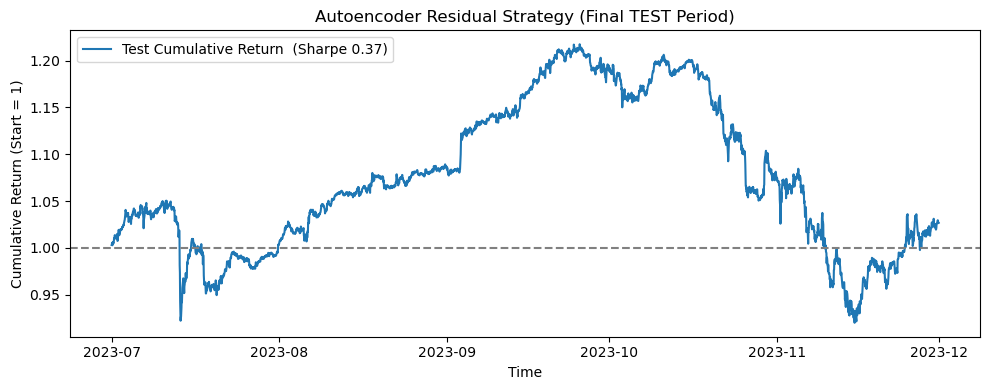

In [404]:
# 11) Plot cumulative return
plt.figure(figsize=(10,4))
plt.plot(cumret_test.index, cumret_test.values,
         label=f"Test Cumulative Return  (Sharpe {sharpe_test:.2f})")
plt.axhline(1.0, linestyle='--', color='gray')
plt.title("Autoencoder Residual Strategy (Final TEST Period)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return (Start = 1)")
plt.legend()
plt.tight_layout()
plt.show()

# Reinforcement Learning

In [435]:
import torch.optim as optim
import random
from collections import deque

# ----------------------------
# 1. ASSUME data_df IS LOADED
# ----------------------------
# data_df: pandas DataFrame containing columns:
#    ['coin_type', 'open_time', 'close']
# plus any previously computed features. We will filter to one coin.

coin = 'BTC'
coin_df = data_df[data_df['coin_type'] == coin].copy()
coin_df = coin_df.sort_values('open_time').reset_index(drop=True)


In [436]:
# ---------------------------------------
# 2. PRECOMPUTE FEATURES FOR THE ENVIRONMENT
# ---------------------------------------
L_r   = 5
L_mom = 24
L_vol = 24

# 2.1) Compute simple return r_t = (P_t / P_{t-1} - 1)
coin_df['return'] = coin_df['close'].pct_change()
coin_df = coin_df.dropna(subset=['return']).reset_index(drop=True)

# 2.2) Rolling momentum over L_mom hours
coin_df['mom'] = coin_df['close'].pct_change(periods=L_mom).fillna(0.0)

# 2.3) Rolling volatility: std of last L_vol returns
coin_df['vol'] = coin_df['return'].rolling(window=L_vol, min_periods=1).std().fillna(0.0)

# 2.4) Build state and next_state arrays
t0 = max(L_r, L_mom, L_vol)
N_total = len(coin_df) - t0 - 1  # we need t+1 to exist for reward

state_dim = L_r + 2  # [lagged returns..., mom, vol]

states = np.zeros((N_total, state_dim), dtype=np.float32)
next_states = np.zeros((N_total, state_dim), dtype=np.float32)
returns_aligned = np.zeros(N_total, dtype=np.float32)

for idx in range(N_total):
    t = t0 + idx
    # --- build current state at time t ---
    r_lags = coin_df['return'].iloc[t - np.arange(1, L_r + 1)].values
    mom_t  = coin_df['mom'].iloc[t]
    vol_t  = coin_df['vol'].iloc[t]
    states[idx] = np.concatenate([r_lags[::-1], np.array([mom_t, vol_t])], axis=0)

    # --- build next-state at time t+1 ---
    t_next = t + 1
    r_lags_next = coin_df['return'].iloc[t_next - np.arange(1, L_r + 1)].values
    mom_next    = coin_df['mom'].iloc[t_next]
    vol_next    = coin_df['vol'].iloc[t_next]
    next_states[idx] = np.concatenate([r_lags_next[::-1], np.array([mom_next, vol_next])], axis=0)

    # --- CORRECT REWARD: return from t → t+1 ---
    returns_aligned[idx] = coin_df['return'].iloc[t_next]

# -----------------------------------
# 3. SPLIT INTO TRAIN / TEST SETS
# -----------------------------------
split_ratio = 0.8
split_idx = int(N_total * split_ratio)

train_states      = states[:split_idx]
train_next_states = next_states[:split_idx]
train_returns     = returns_aligned[:split_idx]

test_states       = states[split_idx:]
test_next_states  = next_states[split_idx:]
test_returns      = returns_aligned[split_idx:]


In [443]:

# -----------------------------------------
# 4. GYM-LIKE ENVIRONMENT FOR SINGLE COIN
# -----------------------------------------
class CryptoTradingEnv:
    def __init__(self, returns, states, next_states, txn_cost=0.0002):
        self.returns      = returns       # length = n_steps
        self.states       = states
        self.next_states  = next_states
        self.txn_cost     = txn_cost
        self.n_steps      = len(returns)
        self.action_map   = {0: -1, 1: 0, 2: +1}
        self.reset()

    def reset(self):
        self.idx         = 0
        self.prev_action = 1   # “1” means “flat” at t = 0
        self.done        = False
        return self.states[self.idx]

    def step(self, action_idx):
        if self.done:
            raise ValueError("Episode done. Call reset().")

        #  (1)  Current index
        curr_idx     = self.idx
        position_t   = self.action_map[action_idx]
        position_prev= self.action_map[self.prev_action]

        #  (2)  Compute reward using returns[curr_idx]
        r_tp1    = self.returns[curr_idx]
        reward   = position_t * r_tp1 \
                   - self.txn_cost * abs(position_t - position_prev)

        #  (3)  Now choose “next_state”
        if curr_idx >= self.n_steps - 1:
            # if this was last step, we are done
            self.done     = True
            next_state    = np.zeros_like(self.states[0], dtype=np.float32)
        else:
            # The correct “next_state” is precisely next_states[curr_idx]
            next_state    = self.next_states[curr_idx]

        #  (4)  Advance index
        self.idx         += 1
        self.prev_action = action_idx

        return next_state, reward, self.done, {}

# Build train / test envs
train_env = CryptoTradingEnv(train_returns,
                             train_states,
                             train_next_states,
                             txn_cost=0.0001)

test_env  = CryptoTradingEnv(test_returns,
                             test_states,
                             test_next_states,
                             txn_cost=0.0001)

In [444]:

# -------------------------------------------
# 5. REPLAY BUFFER FOR DRQN (SEQUENCE SAMPLING)
# -------------------------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def __len__(self):
        return len(self.buffer)

    def sample_sequence(self, batch_size, seq_len):
        N = len(self.buffer)
        if N < seq_len:
            raise ValueError("Not enough transitions.")

        starts = np.random.choice(np.arange(0, N - seq_len), size=batch_size, replace=False)
        states_b, actions_b, rewards_b, next_states_b, dones_b = [], [], [], [], []

        for s in starts:
            seq = [self.buffer[s + i] for i in range(seq_len)]
            ss, aa, rr, nss, dd = zip(*seq)
            states_b.append(np.stack(ss, axis=0))
            actions_b.append(np.array(aa, dtype=np.int64))
            rewards_b.append(np.array(rr, dtype=np.float32))
            next_states_b.append(np.stack(nss, axis=0))
            dones_b.append(np.array(dd, dtype=np.float32))

        states_b      = torch.tensor(np.stack(states_b, axis=0), dtype=torch.float32)
        actions_b     = torch.tensor(np.stack(actions_b, axis=0), dtype=torch.int64)
        rewards_b     = torch.tensor(np.stack(rewards_b, axis=0), dtype=torch.float32)
        next_states_b = torch.tensor(np.stack(next_states_b, axis=0), dtype=torch.float32)
        dones_b       = torch.tensor(np.stack(dones_b, axis=0), dtype=torch.float32)

        return states_b, actions_b, rewards_b, next_states_b, dones_b


In [445]:

# -------------------------------------------
# 6. DRQN NETWORK DEFINITION
# -------------------------------------------
class DRQN(nn.Module):
    def __init__(self, state_dim, hidden_dim, num_actions, num_layers=1):
        super(DRQN, self).__init__()
        self.hidden_dim  = hidden_dim
        self.num_layers  = num_layers
        self.num_actions = num_actions

        self.lstm = nn.LSTM(input_size=state_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, num_actions)

    def forward(self, x, hidden=None):
        lstm_out, hidden_out = self.lstm(x, hidden)
        q_out = self.fc(lstm_out)
        return q_out, hidden_out


In [446]:
# ----------------------------------------------------------
# 7. TRAINING LOOP FOR DRQN
# ----------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate      = 1e-4
gamma              = 0.99
batch_size         = 32
seq_len            = 8
buffer_capacity    = 100_000
hidden_dim         = 128
num_layers         = 1
target_update_freq = 1000
epsilon_start      = 1.0
epsilon_final      = 0.01
epsilon_decay_steps= 100_000

epsilon_by_step = lambda step: max(epsilon_final,
                                   epsilon_start
                                   - (epsilon_start - epsilon_final)
                                     * step / epsilon_decay_steps)

online_net = DRQN(state_dim=state_dim,
                  hidden_dim=hidden_dim,
                  num_actions=3,
                  num_layers=num_layers).to(device)
target_net = DRQN(state_dim=state_dim,
                  hidden_dim=hidden_dim,
                  num_actions=3,
                  num_layers=num_layers).to(device)
target_net.load_state_dict(online_net.state_dict())
target_net.eval()

optimizer = optim.Adam(online_net.parameters(), lr=learning_rate)
buffer_rb  = ReplayBuffer(capacity=buffer_capacity)

global_step     = 0
train_losses    = []
episode_rewards = []

for episode in range(max_episodes):
    state_np = train_env.reset()
    hidden   = None
    ep_reward= 0.0

    for t in range(train_env.n_steps):
        epsilon = epsilon_by_step(global_step)
        state_tensor = torch.tensor(state_np,
                                    dtype=torch.float32)\
                          .unsqueeze(0).unsqueeze(0)\
                          .to(device)

        with torch.no_grad():
            q_values, hidden = online_net(state_tensor, hidden)
            q_values = q_values.squeeze(0).squeeze(0).cpu().numpy()

        if random.random() < epsilon:
            action_idx = random.choice([0, 1, 2])
        else:
            action_idx = int(np.argmax(q_values))

        next_state_np, reward, done, _ = train_env.step(action_idx)
        ep_reward += reward

        buffer_rb.push(state_np,
                       action_idx,
                       reward,
                       next_state_np,
                       float(done))
        state_np = next_state_np
        if done:
            hidden = None

        if len(buffer_rb) >= batch_size * seq_len:
            (states_b,
             actions_b,
             rewards_b,
             next_states_b,
             dones_b) = buffer_rb.sample_sequence(batch_size, seq_len)

            states_b      = states_b.to(device)
            actions_b     = actions_b.to(device)
            rewards_b     = rewards_b.to(device)
            next_states_b = next_states_b.to(device)
            dones_b       = dones_b.to(device)

            q_values_b, _ = online_net(states_b)
            q_value_a     = q_values_b.gather(dim=2,
                                              index=actions_b.unsqueeze(-1)
                                              ).squeeze(-1)

            with torch.no_grad():
                q_next, _    = target_net(next_states_b)
                q_next_max,_ = q_next.max(dim=2)
                q_target     = rewards_b \
                               + gamma * (1.0 - dones_b) * q_next_max

            loss = nn.MSELoss()(q_value_a, q_target)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(online_net.parameters(),
                                     max_norm=1.0)
            optimizer.step()

            train_losses.append(loss.item())
            if global_step % target_update_freq == 0:
                target_net.load_state_dict(online_net.state_dict())
            global_step += 1

        if done:
            break

    episode_rewards.append(ep_reward)
    print(f"Episode {episode+1}/{max_episodes} | "
          f"Train Reward: {ep_reward:.4f} | "
          f"Epsilon: {epsilon:.4f} | "
          f"Buffer Size: {len(buffer_rb)}")

Episode 1/50 | Train Reward: -1.0500 | Epsilon: 0.8706 | Buffer Size: 13322
Episode 2/50 | Train Reward: -0.4344 | Epsilon: 0.7388 | Buffer Size: 26644
Episode 3/50 | Train Reward: -1.0066 | Epsilon: 0.6069 | Buffer Size: 39966
Episode 4/50 | Train Reward: -0.5888 | Epsilon: 0.4750 | Buffer Size: 53288
Episode 5/50 | Train Reward: -0.6860 | Epsilon: 0.3431 | Buffer Size: 66610
Episode 6/50 | Train Reward: -0.0208 | Epsilon: 0.2112 | Buffer Size: 79932
Episode 7/50 | Train Reward: -0.6083 | Epsilon: 0.0793 | Buffer Size: 93254
Episode 8/50 | Train Reward: 0.3795 | Epsilon: 0.0100 | Buffer Size: 100000
Episode 9/50 | Train Reward: 1.0815 | Epsilon: 0.0100 | Buffer Size: 100000
Episode 10/50 | Train Reward: 0.5023 | Epsilon: 0.0100 | Buffer Size: 100000
Episode 11/50 | Train Reward: 0.7873 | Epsilon: 0.0100 | Buffer Size: 100000
Episode 12/50 | Train Reward: 1.1791 | Epsilon: 0.0100 | Buffer Size: 100000
Episode 13/50 | Train Reward: 0.1457 | Epsilon: 0.0100 | Buffer Size: 100000
Episode 

In [447]:

# ---------------------------------
# 8. EVALUATION ON TEST SET & SHARPE
# ---------------------------------
# Run greedy policy (epsilon=0) on test_env

state_np = test_env.reset()
hidden   = None
pnl_list = []
done     = False

while not done:
    state_tensor = torch.tensor(state_np,
                                dtype=torch.float32)\
                      .unsqueeze(0).unsqueeze(0)\
                      .to(device)
    with torch.no_grad():
        q_values, hidden = online_net(state_tensor, hidden)
        action_idx = int(torch.argmax(q_values.squeeze(0).squeeze(0))
                         .cpu().numpy())

    next_state_np, reward, done, _ = test_env.step(action_idx)
    pnl_list.append(reward)
    state_np = next_state_np

pnl_array = np.array(pnl_list, dtype=np.float32)

mean_ret = np.mean(pnl_array)
std_ret  = np.std(pnl_array, ddof=0)
# Annualize from hourly→yearly (8760 ≈ 365*24)
sharpe   = (mean_ret / std_ret) * np.sqrt(8760)

print(f"\n=== TEST SET PERFORMANCE (Corrected) ===")
print(f"Test Steps          = {len(pnl_array)} hours")
print(f"Average Hourly PnL  = {mean_ret:.5f}")
print(f"Std Dev of PnL      = {std_ret:.5f}")
print(f"Annualized Sharpe   = {sharpe:.2f}")


=== TEST SET PERFORMANCE (Corrected) ===
Test Steps          = 3331 hours
Average Hourly PnL  = -0.00006
Std Dev of PnL      = 0.00297
Annualized Sharpe   = -1.77


In [449]:
# cum_pnl   = np.cumprod(1 + pnl_array)
# times_test = coin_df['open_time'].iloc[
#     t0 + split_idx : t0 + split_idx + len(pnl_array)
# ].reset_index(drop=True)

# plt.figure(figsize=(10, 5))
# plt.plot(times_test, cum_pnl, label='DRQN Cumulative PnL (Corrected)')
# plt.xlabel('Time')
# plt.ylabel('Cumulative Return (×1)')
# plt.title(f'DRQN Test Performance on {coin} (Corrected)')
# plt.legend()
# plt.tight_layout()
# plt.show()